In [1]:
from b_cos.resnet import resnet50
from b_cos.bcosconv2d import BcosConv2d
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torchvision import transforms
from tqdm import tqdm

from extract_images import TarImageDataset



class MyToTensor(transforms.ToTensor):

    def __init__(self):
        """
        Same as transforms.ToTensor, except that if input to __call__ is already tensor, the input is returned unchanged
        """
        super().__init__()

    def __call__(self, input_img):
        if not isinstance(input_img, torch.Tensor):
            return super().__call__(input_img)
        return input_img

class AddInverse(nn.Module):

    def __init__(self, dim=1):
        """
            Adds (1-in_tensor) as additional channels to its input via torch.cat().
            Can be used for images to give all spatial locations the same sum over the channels to reduce color bias.
        """
        super().__init__()
        self.dim = dim

    def forward(self, in_tensor):
        out = torch.cat([in_tensor, 1-in_tensor], self.dim)
        return out
    
transform = transforms.Compose([
    # transforms.Resize((224, 224)),  # Resize if necessary
    MyToTensor(),            # Converts image to tensor if not already
    AddInverse(dim=0),            # Adds the inverse channels
])

file_path_fake = [f'../../data/wild_deepfake/fake_train/{i}.tar.gz' for i in range(1, 21)]
file_path_real = [f'../../data/wild_deepfake/real_train/{i}.tar.gz' for i in [1, 2, 4, 6, 11, 12, 13, 16, 17, 18, 19, 20]]
file_paths = file_path_fake + file_path_real

data = TarImageDataset(file_paths, transform=transform)
sample_image, _ = data[0]  # Get a sample image from the dataset

# 2. Define the data loaders
# Split dataset into training and validation sets
train_size = int(0.8 * len(data))  # 80% for training
val_size = len(data) - train_size   # 20% for validation
train_data, val_data = random_split(data, [train_size, val_size])

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [2]:
import torch
from torch.hub import load_state_dict_from_url
import torch.nn as nn

def load_pretrained_weights(model, model_url):
    # Load the state dict from the URL
    state_dict = load_state_dict_from_url(model_url, progress=True)

    # Rename keys to match custom model layer names and initialize adapted state dict
    adapted_state_dict = {}
    for key, value in state_dict.items():
        # Replace ".weight" with ".linear.weight" if necessary for `BcosConv2d`
        new_key = key.replace("conv", "conv.linear").replace("fc", "fc.linear")
        
        # Only add weights if the shape matches the model's layer
        if new_key in model.state_dict() and model.state_dict()[new_key].shape == value.shape:
            adapted_state_dict[new_key] = value

    # Load the adapted state dict with partial loading (non-strict mode)
    model.load_state_dict(adapted_state_dict, strict=False)

    # Reinitialize the final layer to match the desired output shape (for 2 classes)
    nn.init.kaiming_normal_(model.fc.linear.weight)
    if model.fc.linear.bias is not None:
        model.fc.linear.bias.data.zero_()  # Initialize bias to zero if it exists

# Usage with resnet50
model = resnet50(pretrained=False, progress=True, num_classes=1, groups=32, width_per_group=4)
load_pretrained_weights(model, 'https://download.pytorch.org/models/resnet50-19c8e357.pth')

In [14]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
fraction = 0.1
num_batches = int(len(train_loader) * fraction)

# Training loop with limited batches
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, total=num_batches, desc=f'Epoch [{epoch + 1}/{num_epochs}]')
    for batch_idx, (images, labels) in enumerate(progress_bar):
        if batch_idx >= num_batches:
            break  # Stop after reaching the fraction of batches

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        # outputs = outputs.view(outputs.size(0), -1) NEEDED WHEN USING CROSS ENTROPY LOSS & num_classes > 1

        # Convert labels to float for BCEWithLogitsLoss
        labels = labels.float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix({'Loss': running_loss / (batch_idx + 1)})
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / num_batches:.4f}')

Epoch [1/5]: 100%|██████████| 186/186 [01:38<00:00,  1.89it/s, Loss=21.7] 


Epoch [1/5], Loss: 21.7112


Epoch [2/5]: 100%|██████████| 186/186 [01:37<00:00,  1.90it/s, Loss=0.678]


Epoch [2/5], Loss: 0.6784


Epoch [3/5]: 100%|██████████| 186/186 [01:38<00:00,  1.90it/s, Loss=0.738]


Epoch [3/5], Loss: 0.7377


Epoch [4/5]: 100%|██████████| 186/186 [01:37<00:00,  1.90it/s, Loss=0.674]


Epoch [4/5], Loss: 0.6743


Epoch [5/5]: 100%|██████████| 186/186 [01:37<00:00,  1.90it/s, Loss=0.601]

Epoch [5/5], Loss: 0.6014


In [15]:
torch.save(model.state_dict(), 'b_cos_model_2.pth')

## Heatmaps

In [16]:
import numpy as np
import torch.nn.functional as F
def to_numpy(tensor):
    """
    Converting tensor to numpy.
    Args:
        tensor: torch.Tensor

    Returns:
        Tensor converted to numpy.

    """
    if not isinstance(tensor, torch.Tensor):
        return tensor
    return tensor.detach().cpu().numpy()

def grad_to_img(img, linear_mapping, smooth=15, alpha_percentile=99.5):
    """
    Computing color image from dynamic linear mapping of B-cos models.
    Args:
        img: Original input image (encoded with 6 color channels)
        linear_mapping: linear mapping W_{1\rightarrow l} of the B-cos model
        smooth: kernel size for smoothing the alpha values
        alpha_percentile: cut-off percentile for the alpha value

    Returns:
        image explanation of the B-cos model
    """
    # shape of img and linmap is [C, H, W], summing over first dimension gives the contribution map per location
    contribs = (img * linear_mapping).sum(0, keepdim=True)
    contribs = contribs[0]
    # Normalise each pixel vector (r, g, b, 1-r, 1-g, 1-b) s.t. max entry is 1, maintaining direction
    rgb_grad = (linear_mapping / (linear_mapping.abs().max(0, keepdim=True)[0] + 1e-12))
    # clip off values below 0 (i.e., set negatively weighted channels to 0 weighting)
    rgb_grad = rgb_grad.clamp(0)
    # normalise s.t. each pair (e.g., r and 1-r) sums to 1 and only use resulting rgb values
    rgb_grad = to_numpy(rgb_grad[:3] / (rgb_grad[:3] + rgb_grad[3:]+1e-12))

    # Set alpha value to the strength (L2 norm) of each location's gradient
    alpha = (linear_mapping.norm(p=2, dim=0, keepdim=True))
    # Only show positive contributions
    alpha = torch.where(contribs[None] < 0, torch.zeros_like(alpha) + 1e-12, alpha)
    if smooth:
        alpha = F.avg_pool2d(alpha, smooth, stride=1, padding=(smooth-1)//2)
    alpha = to_numpy(alpha)
    alpha = (alpha / np.percentile(alpha, alpha_percentile)).clip(0, 1)

    rgb_grad = np.concatenate([rgb_grad, alpha], axis=0)
    # Reshaping to [H, W, C]
    grad_image = rgb_grad.transpose((1, 2, 0))
    return grad_image

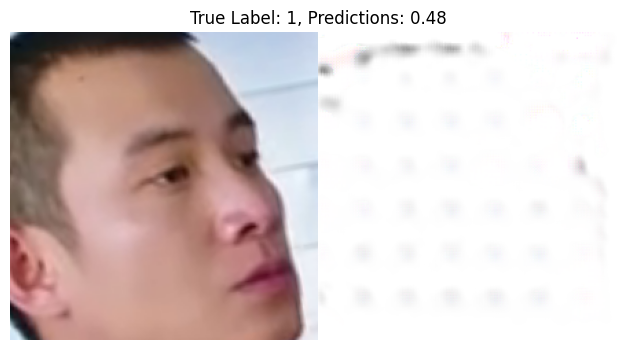

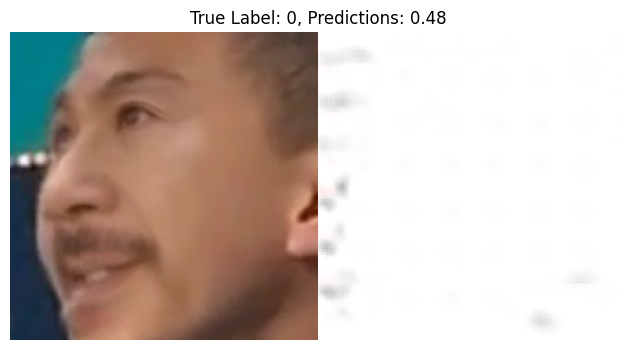

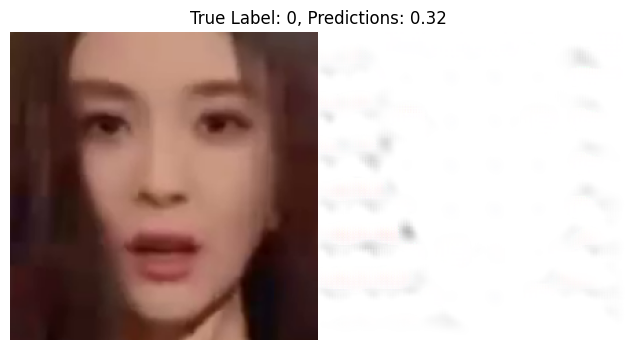

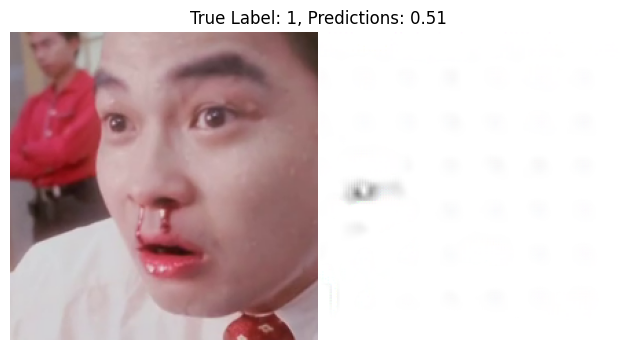

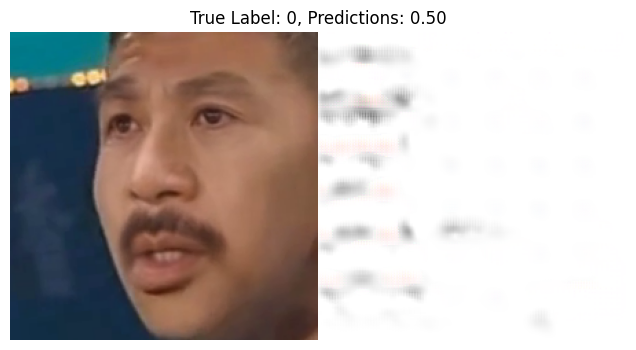

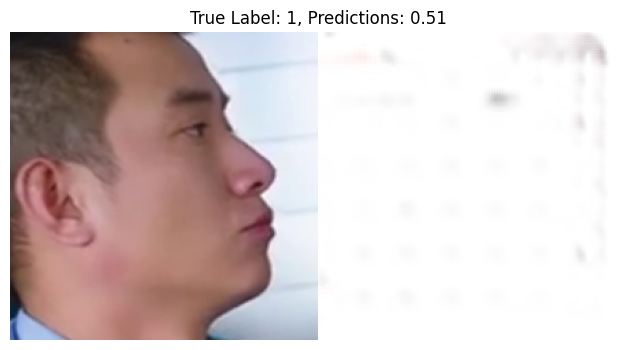

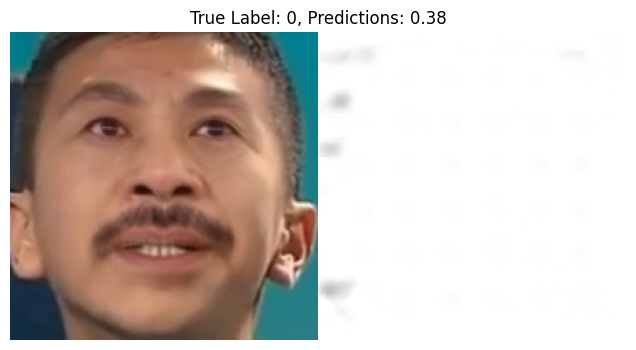

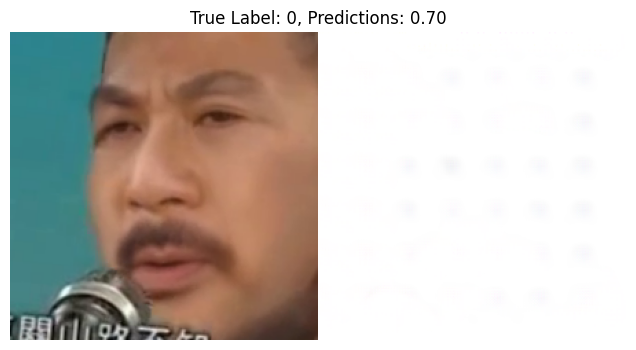

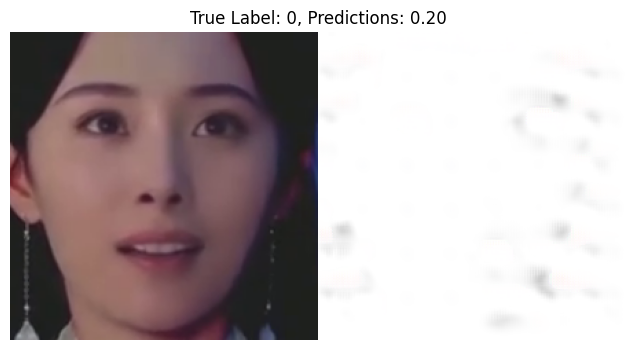

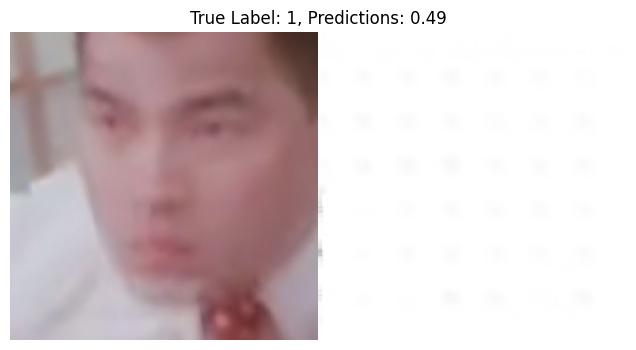

In [ ]:
for idx in range(10):
    img, label = val_data[idx]
    img = img.unsqueeze(0).to(device)
    # img = train_loader.dataset[0][0].unsqueeze(0).to(device)
    img = img.requires_grad_(True)
    # print(f"True Label: {label}")

    # model.get_features(img)
    model.zero_grad()
    out = model(img)
    # print(f"Predictions: {out.sigmoid()}")
    out.backward()

    att = grad_to_img(img[0], img.grad[0], alpha_percentile=100, smooth=5)
    att[..., -1] *= to_numpy(out.sigmoid())

    # print(to_numpy(att))

    # atts.append(to_numpy(att))
    # print(np.array(to_numpy(img[0, :3].permute(1, 2, 0)) * 255, dtype=np.uint8))
    att = to_numpy(att)
    img = np.array(to_numpy(img[0, :3].permute(1, 2, 0)) * 255, dtype=np.uint8)
    # imgs.append(np.array(to_numpy(img[0, :3].permute(1, 2, 0)) * 255, dtype=np.uint8))
    fig, ax = plt.subplots(1, figsize=(8, 4))
    plt.imshow(img, extent=(0, 224, 0, 224))
    plt.imshow(att, extent=(224, 2 * 224, 0, 224))
    plt.xlim(0, 2 * 224)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"True Label: {label}, Predictions: {out.sigmoid().item():.2f}")
    for spine in ax.spines.values():
        spine.set_visible(False)

In [ ]:
model = resnet50(pretrained=False, progress=True, num_classes=2,)# groups=32, width_per_group=4)

# Step 2: Load the saved state dictionary
model.load_state_dict(torch.load('b_cos_model.pth'))

# Assume your model, TarImageDataset, and necessary imports are already in place
test_file_path_fake = [f'../../data/wild_deepfake/fake_test/{i}.tar.gz' for i in range(1, 11)]
test_file_path_real = [f'../../data/wild_deepfake/real_test/{i}.tar.gz' for i in [3, 6, 8, 9]]
test_file_paths = test_file_path_fake + test_file_path_real

# Create the test dataset and DataLoader
test_dataset = TarImageDataset(test_file_paths, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set model to evaluation mode
model.eval()

# Lists to store all predictions and true labels
all_preds = []
all_labels = []

# Disable gradient calculation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move to device
        outputs = model(images)  # Forward pass
        outputs = outputs.view(outputs.size(0), -1)
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())  # Store true labels

# Calculate and print the accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy:.2f}')

# Detailed classification report
print(classification_report(all_labels, all_preds, target_names=['Fake', 'Real']))
print(confusion_matrix(all_labels, all_preds))